- https://albertauyeung.github.io/2017/04/23/python-matrix-factorization.html

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import boxcox, inv_boxcox
from scipy import stats
from PIL import Image

from fastai.tabular.all import *
from fastai.collab import *

# Aux funcs

In [2]:
def create_matrix(df, varUser, varItem, varRating, constantValue=False):
    
    real_userIds = df[varUser].unique().tolist()
    real_itemIds = df[varItem].unique().tolist()
    
    range_userIds = list(range(len(real_userIds)))
    range_itemIds = list(range(len(real_itemIds)))
    
    get_userId = dict(zip(real_userIds,range_userIds))
    get_itemId = dict(zip(real_itemIds,range_itemIds))
        
    matrix = np.zeros((len(real_userIds),len(real_itemIds)), dtype=np.uint8)
    
    for index, row in df.iterrows():
        
        userId = get_userId[row[varUser]]
        itemId = get_itemId[row[varItem]]
        if constantValue:
            matrix[userId, itemId] = 255
        else:
            matrix[userId, itemId] = row[varRating]
        
    return matrix

def explore_matrix(df, varUser, varItem, varRating):
    num_of_users = df[varUser].nunique()
    num_of_items = df[varItem].nunique()
    num_of_pairs = len(df)
    matrix_size = num_of_users * num_of_items
    
    print("Number of users:", num_of_users)
    print("Number of items:", num_of_items)
    print("Number of interactions:", num_of_pairs, "(", round((num_of_pairs/matrix_size)*100,2), "%)" )
    
    matrix = create_matrix(df, varUser, varItem, varRating, constantValue=True)
    """
    plt.title('Compañia '+ str(comp_id))
    plt.xlabel('Productos')
    plt.ylabel('Usuarios')
    plt.imshow( matrix, interpolation='nearest')
    plt.show()
    """;
    
    display(Image.fromarray(matrix))

# Datos Fastai

In [3]:
path = untar_data(URLs.ML_100k)
df_fastai = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      usecols=(0,1,2), names=['user','movie','rating'])
df_fastai.head()

,user,movie,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [4]:
m = create_matrix(df_fastai, "user", "movie", "rating")
m

array([[3, 0, 0, ..., 0, 0, 0],
       [0, 3, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 4, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

Number of users: 943
Number of items: 1682
Number of interactions: 100000 ( 6.3 %)


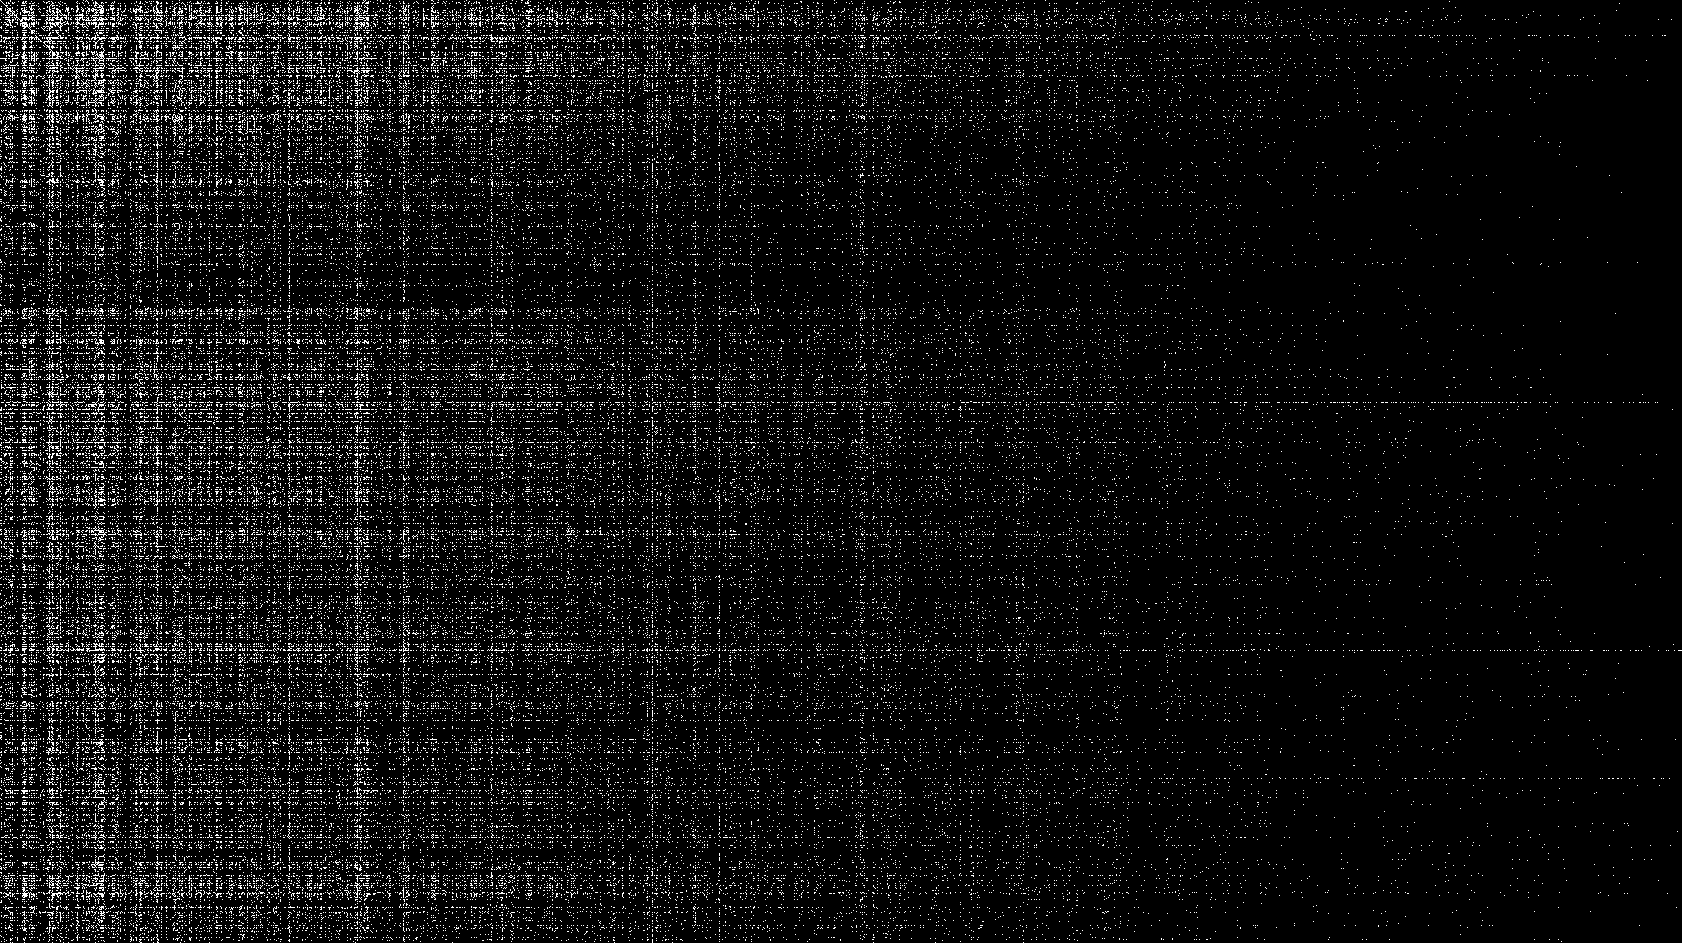

In [5]:
explore_matrix(df_fastai, "user", "movie", "rating")

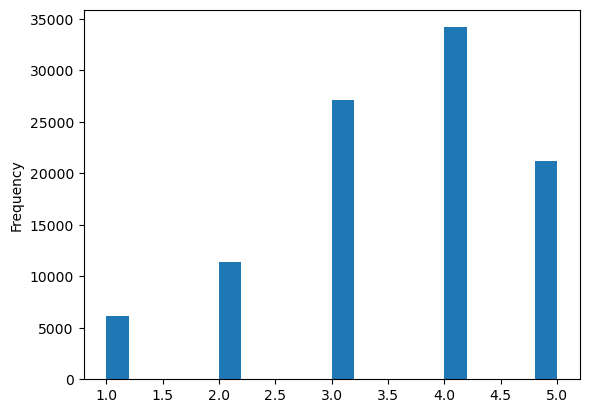

In [6]:
df_fastai.rating.plot.hist(bins=20);

In [7]:
dls = CollabDataLoaders.from_df(ratings=df_fastai,
                                valid_pct=0.2,
                                user_name="user",
                                item_name="movie",
                                rating_name="rating",
                                seed=None,
                                bs=64)

### Train (loss is MSE)

In [8]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5), metrics=[mae])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,mae,time
0,0.958396,0.932351,0.768780,00:04
1,0.892684,0.859221,0.735014,00:04
2,0.709805,0.816669,0.713908,00:04
3,0.602730,0.797639,0.705190,00:04
4,0.496226,0.798547,0.705297,00:04


In [8]:
5e-3

0.005

In [16]:
class MatrixFactorization():

    def __init__(self, matrix, embSize, lr, wd, iterations, train_perc=1):
        """
        Perform matrix factorization to predict empty
        entries in a matrix.

        Arguments
        - matrix (ndarray) : user-item rating matrix
        - embSize (int)    : number of latent dimensions
        - lr (float)       : learning rate
        - wd (float)       : regularization parameter
        """

        self.matrix = matrix
        self.num_users, self.num_items = matrix.shape
        self.embSize = embSize
        self.lr = lr
        self.wd = wd
        self.iterations = iterations
        self.train_perc = train_perc

    def train(self):
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./self.embSize, size=(self.num_users, self.embSize))
        self.Q = np.random.normal(scale=1./self.embSize, size=(self.num_items, self.embSize))

        # Initialize the biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.matrix[np.where(self.matrix != 0)])

        # Create a list of samples
        samples = [
            (i, j, self.matrix[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.matrix[i, j] > 0
        ]
        # Separate training and validation samples
        np.random.shuffle(samples)
        split_idx = int(len(samples) * self.train_perc)
        self.train_samples = samples[:split_idx]
        self.valid_samples = samples[split_idx:]

        # Perform stochastic gradient descent for number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.train_samples)
            self.sgd()
            train_mae, train_mse, valid_mae, valid_mse = self.errors()
            training_process.append((i, valid_mse))
            #if (i+1) % 10 == 0:
            print("Iteration: %d ; trMAE = %.4f trMSE = %.4f valMAE = %.4f valMSE = %.4f" % (i+1, train_mae, train_mse, valid_mae, valid_mse))

        return training_process

    
    def errors(self):
        """
        A function to compute the errors
        """
        predicted = self.full_matrix()
        
        train_mae = 0
        train_mse = 0
        for x, y, real in self.train_samples:
            diference = real - predicted[x, y]
            train_mae += abs(diference)
            train_mse += pow(diference, 2)
        train_mae /= len(self.train_samples)
        train_mse /= len(self.train_samples)

        valid_mae = 0
        valid_mse = 0
        for x, y, real in self.valid_samples:
            diference = real - predicted[x, y]
            valid_mae += abs(diference)
            valid_mse += pow(diference, 2)  
        valid_mae /= len(self.valid_samples)
        valid_mse /= len(self.valid_samples)
        
        return train_mae, train_mse, valid_mae, valid_mse
        

    def sgd(self):
        """
        Perform stochastic graident descent
        """
        for i, j, r in self.train_samples:
            # Computer prediction and error
            prediction = self.get_rating(i, j)
            e = (r - prediction)

            # Update biases
            self.b_u[i] += self.lr * (e - self.wd * self.b_u[i])
            self.b_i[j] += self.lr * (e - self.wd * self.b_i[j])

            # Update user and item embeddings
            self.P[i, :] += self.lr * (e * self.Q[j, :] - self.wd * self.P[i,:])
            self.Q[j, :] += self.lr * (e * self.P[i, :] - self.wd * self.Q[j,:])

    def get_rating(self, i, j):
        """
        Get the predicted rating of user i and item j
        """
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    def full_matrix(self):
        """
        Computer the full matrix using the resultant biases, P and Q
        """
        return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)

In [17]:
mf = MatrixFactorization(matrix=m, embSize=50, lr=0.05, wd=0.1, iterations=20, train_perc=0.8)
training_process = mf.train()

Iteration: 1 ; trMAE = 0.7450 trMSE = 0.8817 valMAE = 0.7623 valMSE = 0.9253
Iteration: 2 ; trMAE = 0.7400 trMSE = 0.8651 valMAE = 0.7599 valMSE = 0.9139
Iteration: 3 ; trMAE = 0.7322 trMSE = 0.8535 valMAE = 0.7555 valMSE = 0.9087
Iteration: 4 ; trMAE = 0.7188 trMSE = 0.8241 valMAE = 0.7477 valMSE = 0.8953
Iteration: 5 ; trMAE = 0.7032 trMSE = 0.7850 valMAE = 0.7413 valMSE = 0.8751
Iteration: 6 ; trMAE = 0.6848 trMSE = 0.7435 valMAE = 0.7357 valMSE = 0.8646
Iteration: 7 ; trMAE = 0.6631 trMSE = 0.6952 valMAE = 0.7323 valMSE = 0.8601
Iteration: 8 ; trMAE = 0.6374 trMSE = 0.6420 valMAE = 0.7270 valMSE = 0.8497
Iteration: 9 ; trMAE = 0.6121 trMSE = 0.5922 valMAE = 0.7255 valMSE = 0.8443
Iteration: 10 ; trMAE = 0.5908 trMSE = 0.5520 valMAE = 0.7226 valMSE = 0.8419
Iteration: 11 ; trMAE = 0.5721 trMSE = 0.5155 valMAE = 0.7252 valMSE = 0.8440
Iteration: 12 ; trMAE = 0.5558 trMSE = 0.4880 valMAE = 0.7262 valMSE = 0.8461
Iteration: 13 ; trMAE = 0.5411 trMSE = 0.4650 valMAE = 0.7242 valMSE = 0.

In [19]:
mf = MF(matrix=m, embSize=50, lr=0.01, wd=0.1, iterations=20, train_perc=0.8)
training_process = mf.train()

Iteration: 1 ; trMAE = 0.7754 trMSE = 0.9392 valMAE = 0.7803 valMSE = 0.9519
Iteration: 2 ; trMAE = 0.7542 trMSE = 0.8944 valMAE = 0.7614 valMSE = 0.9169
Iteration: 3 ; trMAE = 0.7444 trMSE = 0.8754 valMAE = 0.7532 valMSE = 0.9029
Iteration: 4 ; trMAE = 0.7403 trMSE = 0.8653 valMAE = 0.7507 valMSE = 0.8968
Iteration: 5 ; trMAE = 0.7359 trMSE = 0.8580 valMAE = 0.7477 valMSE = 0.8926
Iteration: 6 ; trMAE = 0.7342 trMSE = 0.8534 valMAE = 0.7465 valMSE = 0.8898
Iteration: 7 ; trMAE = 0.7325 trMSE = 0.8498 valMAE = 0.7455 valMSE = 0.8880
Iteration: 8 ; trMAE = 0.7306 trMSE = 0.8473 valMAE = 0.7444 valMSE = 0.8864
Iteration: 9 ; trMAE = 0.7301 trMSE = 0.8451 valMAE = 0.7446 valMSE = 0.8854
Iteration: 10 ; trMAE = 0.7288 trMSE = 0.8430 valMAE = 0.7431 valMSE = 0.8837
Iteration: 11 ; trMAE = 0.7288 trMSE = 0.8418 valMAE = 0.7442 valMSE = 0.8848
Iteration: 12 ; trMAE = 0.7275 trMSE = 0.8396 valMAE = 0.7429 valMSE = 0.8827
Iteration: 13 ; trMAE = 0.7272 trMSE = 0.8382 valMAE = 0.7431 valMSE = 0.

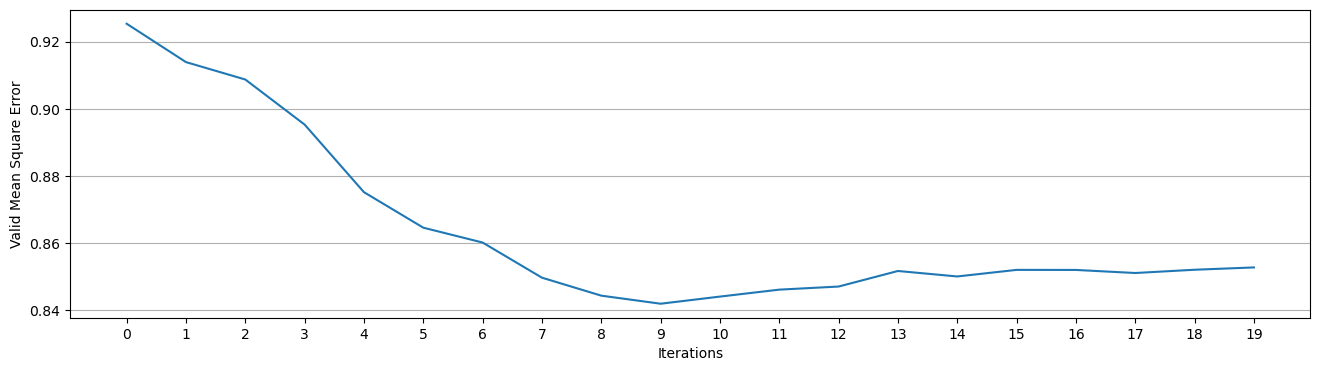

In [18]:
x = [x for x, y in training_process]
y = [y for x, y in training_process]
plt.figure(figsize=((16,4)))
plt.plot(x, y)
plt.xticks(x, x)
plt.xlabel("Iterations")
plt.ylabel("Valid Mean Square Error")
plt.grid(axis="y")

In [ ]:
training_process

# Datios Intelia

Se pueden realizar pruebas con cualquier compañía pero me gustaría empezar por la 23 y 15.

In [9]:
!ls data

customers.csv  products.csv  relation.csv


In [10]:
dataPath = "data/"

df_products = pd.read_csv(dataPath + "products.csv")
df_clients  = pd.read_csv(dataPath + "customers.csv")
df_relation = pd.read_csv(dataPath + "relation.csv")

/tmp/ipykernel_541/3227325611.py:3: DtypeWarning: Columns (20,32,34,39) have mixed types. Specify dtype option on import or set low_memory=False.
  df_products = pd.read_csv(dataPath + "products.csv")
/tmp/ipykernel_541/3227325611.py:4: DtypeWarning: Columns (7,9,10,11,12,13,17,18,21,26,27,28,30,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df_clients  = pd.read_csv(dataPath + "customers.csv")


In [11]:
df_relation.sample(10)

,company_id,product_id,customer_id,peso,ultimo
10805,1,139,99387,135.00,2022-09-28 21:13:41
338862,39,123732,359443,3.00,2021-07-25 00:00:00
77195,15,29022,54203,0.02,2022-02-14 12:28:18
419790,39,123742,324449,3.00,2021-05-20 00:00:00
282011,39,123728,447893,3.00,2021-09-19 00:00:00
578865,39,124589,342405,3.00,2022-05-25 00:00:00
493025,39,123772,383601,3.00,2019-05-30 00:00:00
513505,39,123779,475384,3.00,2021-11-01 00:00:00
220363,23,55570,109950,3.08,2022-01-14 16:33:32
187823,23,52700,106789,3.00,2017-05-04 11:48:14


## No hay duplicados

In [39]:
df_relation [ df_relation[["company_id", "product_id", "customer_id"]].duplicated() ]

,company_id,product_id,customer_id,peso,ultimo,peso_boxcox


In [40]:
df_relation [ df_relation[["product_id", "customer_id"]].duplicated() ]

,company_id,product_id,customer_id,peso,ultimo,peso_boxcox


## Compañias

In [12]:
company_ids = df_relation.company_id.unique()#.tolist()
company_ids

array([ 1,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 15, 16, 18, 19, 21,
       23, 24, 29, 30, 31, 32, 33, 34, 35, 36, 39, 40, 44])

=============================== Company: 1
Number of users: 314
Number of items: 296
Number of interactions: 14902 ( 16.03 %)


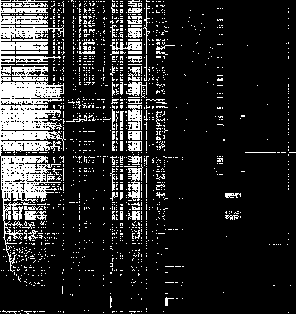

=============================== Company: 3
Number of users: 384
Number of items: 65
Number of interactions: 847 ( 3.39 %)


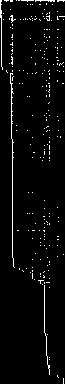

=============================== Company: 4
Number of users: 2
Number of items: 3
Number of interactions: 5 ( 83.33 %)


=============================== Company: 5
Number of users: 21
Number of items: 111
Number of interactions: 419 ( 17.98 %)


=============================== Company: 6
Number of users: 244
Number of items: 749
Number of interactions: 4990 ( 2.73 %)


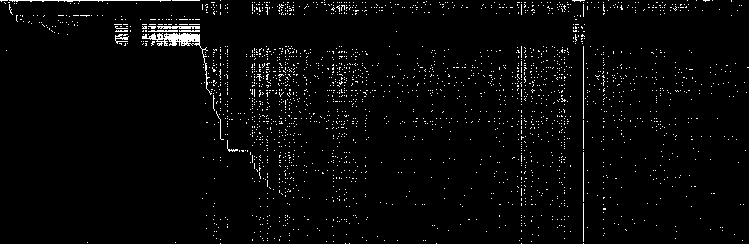

=============================== Company: 7
Number of users: 6
Number of items: 34
Number of interactions: 41 ( 20.1 %)


In [13]:
for comp_id in company_ids[:6]:
    print("=============================== Company:", comp_id)
    df = df_relation[ df_relation.company_id==comp_id ]
    explore_matrix(df, "customer_id", "product_id")

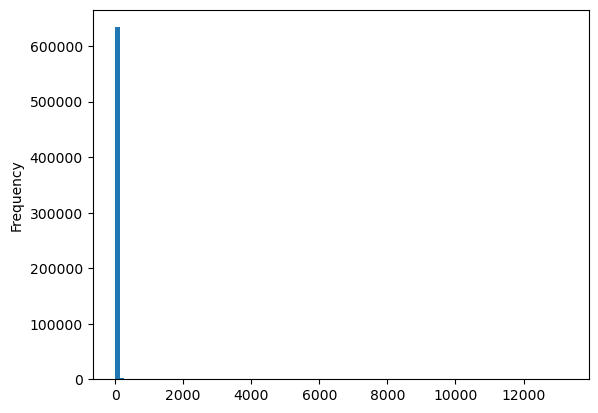

In [14]:
df_relation.peso.plot.hist(bins=100);

In [15]:
df_relation.peso.value_counts().head(20)

3.00     486844
6.00      33501
0.02      21406
0.04      13140
0.08      10703
0.06       9587
9.00       9328
12.00      5095
0.12       2948
15.00      2832
18.00      2299
3.04       2212
3.02       2116
0.16       2106
3.06       1671
3.08       1631
21.00      1618
24.00      1414
0.10       1154
27.00      1019
Name: peso, dtype: int64

In [16]:
df_relation["peso_boxcox"], lmbda = stats.boxcox(df_relation.peso)
print(lmbda)
df_relation

0.18333853353644136


,company_id,product_id,customer_id,peso,ultimo,peso_boxcox
0,1,1,3,6.0,2018-11-29 00:28:00,2.121110
1,1,1,5,183.0,2022-08-29 15:18:18,8.721185
2,1,1,6,6.0,2018-12-24 19:41:00,2.121110
3,1,1,7,39.0,2022-04-29 13:56:42,5.222620
4,1,1,8,3.0,2019-10-10 20:11:00,1.217070
...,...,...,...,...,...,...
636562,40,126862,510949,3.0,2022-10-03 00:20:19,1.217070
636563,40,126863,537570,3.0,2022-10-02 13:39:19,1.217070
636564,40,126864,510626,3.0,2022-10-02 21:58:56,1.217070
636565,40,126971,509931,3.0,2022-10-02 22:42:54,1.217070


<AxesSubplot:ylabel='Frequency'>

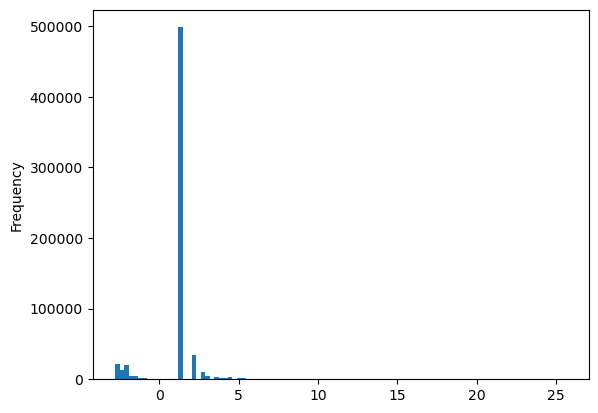

In [17]:
df_relation.peso_boxcox.plot.hist(bins=100)

In [18]:
df_relation.peso_boxcox.min(), df_relation.peso_boxcox.max()

(-2.7920748927290626, 25.626627721213385)

In [19]:
df_comp23_relation = df_relation[ df_relation.company_id==23 ]
df_comp23_relation

,company_id,product_id,customer_id,peso,ultimo,peso_boxcox
146424,23,28888,118364,0.08,2022-08-12 20:15:34,-2.021655
146425,23,28890,532280,0.08,2022-08-12 20:08:26,-2.021655
146426,23,28891,101041,0.08,2022-08-12 19:06:38,-2.021655
146427,23,28892,116295,0.08,2022-08-12 11:14:09,-2.021655
146428,23,28893,117588,0.08,2022-08-13 04:15:28,-2.021655
...,...,...,...,...,...,...
636512,23,57621,537317,0.04,2022-01-14 10:09:18,-2.431308
636513,23,57739,537317,0.04,2022-01-14 10:09:08,-2.431308
636514,23,58193,111111,0.04,2022-10-02 23:16:52,-2.431308
636515,23,58743,537565,0.04,2022-08-26 19:25:13,-2.431308


In [20]:
dls = CollabDataLoaders.from_df(ratings=df_comp23_relation,
                                valid_pct=0.2,
                                user_name="customer_id",
                                item_name="product_id",
                                rating_name="peso_boxcox",
                                seed=None,
                                bs=64)

In [21]:
dls.show_batch()

,customer_id,product_id,peso_boxcox
0,103678,52095,1.217070
1,106182,52128,1.217070
2,102466,54429,-2.431309
3,119814,55365,1.217070
4,101704,51626,1.217070
5,104603,54587,3.163362
6,109085,51529,1.288723
7,104647,51473,1.217070
8,102744,50469,1.217070
9,112106,55206,1.217070


In [22]:
learn = collab_learner(dls, n_factors=50, y_range=(-3, 26), metrics=[mae])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,mae,time
0,32.867165,29.344473,4.384726,00:04
1,9.773914,11.014664,2.173610,00:04
2,5.756277,9.591437,1.962001,00:04
3,3.518925,9.243389,1.878011,00:04
4,2.503077,9.206673,1.863185,00:04


In [28]:
learn = collab_learner(dls, n_factors=50, y_range=(-3, 26), metrics=[mae])
learn.fit_one_cycle(5, lr_max=5e-3, wd=0.1)

epoch,train_loss,valid_loss,mae,time
0,31.172041,28.926107,4.342701,00:04
1,9.897020,10.968962,2.173523,00:04
2,5.556270,9.571959,1.960996,00:04
3,3.596327,9.269145,1.884384,00:04
4,2.608569,9.222979,1.863855,00:04


In [34]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(17393, 50)
  (i_weight): Embedding(5989, 50)
  (u_bias): Embedding(17393, 1)
  (i_bias): Embedding(5989, 1)
)

In [35]:
learn.model.u_weight

Embedding(17393, 50)

In [36]:
learn.model.u_weight.weight

Parameter containing:
tensor([[-0.0016,  0.0037,  0.0010,  ..., -0.0008,  0.0040, -0.0041],
        [-0.0716, -0.0509, -0.0683,  ..., -0.0347,  0.0673, -0.0733],
        [-0.0760, -0.0918, -0.0785,  ..., -0.0951,  0.0828, -0.0619],
        ...,
        [-0.0818, -0.0723, -0.0730,  ..., -0.0711,  0.0745,  0.0753],
        [-0.0226, -0.0100, -0.0013,  ..., -0.0036,  0.0172,  0.0155],
        [-0.0749, -0.0751, -0.0781,  ..., -0.0733,  0.0790,  0.0556]],
       device='cuda:0', requires_grad=True)

In [48]:
0.91**2

0.8281000000000001